
# First Analysis

In [387]:
import pandas as pd
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, IsolationForest
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score
from sklearn.datasets import make_classification
from xgboost import XGBClassifier

In [388]:
da = pd.read_csv('Borehole_Data.csv')
#remove records with misising wellnum details
da2=da.loc[da['WELLNUM'] != 0]
imputer = IterativeImputer(max_iter = 15, random_state=0)
data = pd.DataFrame(imputer.fit_transform(da2), columns=da2.columns)
g=[]
for i in data['CALI'].values/data['BS'].values:
   
   if np.abs(i) > 1.02 or np.abs(i)<0.98:
       g.append(0)
   else:
       g.append(1)    
gg = np.array(g)
data['Ra'] = data['CALI']/data['BS']
data['Ra_C'] = gg
#test and train data
test=data.loc[data['WELLNUM'] == 5]
test_labels = test['Ra_C']
train=data.loc[data['WELLNUM'] != 5]
train_labels = train['Ra_C']

#drop irrelevant columns
train.drop(['DTC', 'DTS', 'WELLNUM', 'DEPTH', 'VSH', 'BS', 'CALI', 'Ra', 'Ra_C'], axis=1, inplace=True)
test.drop(['DTC', 'DTS', 'WELLNUM', 'DEPTH', 'VSH', 'BS', 'CALI','Ra', 'Ra_C'], axis=1, inplace=True)
# # Linear Regression
rf=RandomForestClassifier(n_estimators=150, max_depth=30, min_samples_leaf=3, random_state=42)
rf.fit(train,train_labels)
predictions= rf.predict(test)


conf_matrix = confusion_matrix(test_labels, predictions)
conf_matrix_df = pd.DataFrame(conf_matrix, 
                              index=['Actual Negative', 'Actual Positive'], 
                              columns=['Predicted Negative', 'Predicted Positive'])



recall = recall_score(test_labels, predictions) 
print(f"Recall: {recall}")

# Calculate precision
precision = precision_score(test_labels, predictions)  # For binary classification
print(f"Precision: {precision}")

f1 = f1_score(predictions,test_labels)
print(f"F1 Score: {f1}")
conf_matrix_df

C:\Users\desti\AppData\Local\Temp\ipykernel_16684\130884061.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.drop(['DTC', 'DTS', 'WELLNUM', 'DEPTH', 'VSH', 'BS', 'CALI', 'Ra', 'Ra_C'], axis=1, inplace=True)
C:\Users\desti\AppData\Local\Temp\ipykernel_16684\130884061.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop(['DTC', 'DTS', 'WELLNUM', 'DEPTH', 'VSH', 'BS', 'CALI','Ra', 'Ra_C'], axis=1, inplace=True)


Recall: 0.9373522458628841
Precision: 0.7669245647969052
F1 Score: 0.8436170212765958


,Predicted Negative,Predicted Positive
Actual Negative,319,241
Actual Positive,53,793


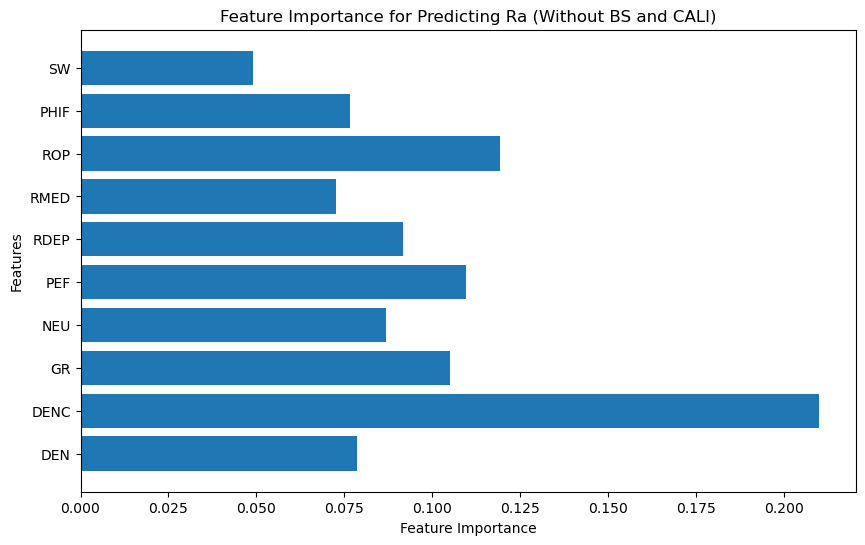

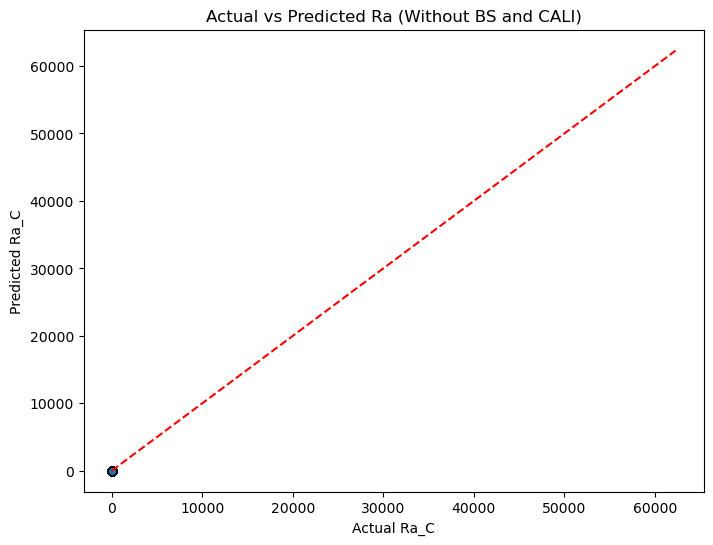

In [390]:
feature_importances = rf.feature_importances_
features = train.columns

# Plot Feature Importances
plt.figure(figsize=(10, 6))
plt.barh(features, feature_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance for Predicting Ra (Without BS and CALI)')
plt.show()

# Plot Predicted vs Actual Values
plt.figure(figsize=(8, 6))
plt.scatter(test_labels, predictions, edgecolor='k', alpha=0.7)
plt.plot([test.min(), test.max()], [test.min(), test.max()], 'r--')
plt.xlabel('Actual Ra_C')
plt.ylabel('Predicted Ra_C')
plt.title('Actual vs Predicted Ra (Without BS and CALI)')
plt.show()

# Isolation  Forest applied before BS/CALI filter

In [374]:
# Initialize the IterativeImputer
imputer = IterativeImputer(max_iter=15, random_state=0)
data = pd.DataFrame(imputer.fit_transform(da2), columns=da2.columns)

# Loop over different contamination values
contamination_values = [0.025, 0.05, 0.1, 0.15, 0.2] 
results = []

for contamination in contamination_values:
    isolation_forest = IsolationForest(contamination=contamination, random_state=0)
    
    # Fit the model and predict outliers
    outliers = isolation_forest.fit_predict(data)
    
    # Filter out the outliers
    filtered_data = data[outliers != -1]
    g = []
    for i in filtered_data['CALI'].values / filtered_data['BS'].values:
        if np.abs(i) > 1.02 or np.abs(i) < 0.98:
            g.append(0)
        else:
            g.append(1)
    
    gg = np.array(g)
    filtered_data['Ra'] = filtered_data['CALI'] / data['BS']
    filtered_data['Ra_C'] = gg
    
    # Test and train data
    test = filtered_data.loc[filtered_data['WELLNUM'] == 5]
    test_labels = test['Ra_C']
    train = filtered_data.loc[filtered_data['WELLNUM'] != 5]
    train_labels = train['Ra_C']
    
    # Drop irrelevant columns
    train.drop(['DTC', 'DTS', 'WELLNUM', 'DEPTH', 'VSH', 'BS', 'CALI', 'Ra', 'Ra_C'], axis=1, inplace=True)
    test.drop(['DTC', 'DTS', 'WELLNUM', 'DEPTH', 'VSH', 'BS', 'CALI', 'Ra', 'Ra_C'], axis=1, inplace=True)
    
    # Train the RandomForestClassifier
    rf = RandomForestClassifier(n_estimators=150, max_depth=30, min_samples_leaf=3, random_state = 0)
    rf.fit(train, train_labels)
    predictions = rf.predict(test)
    conf_matrix = confusion_matrix(test_labels, predictions)
    
   
    f1 = f1_score(test_labels, predictions)
    
   
    conf_matrix_df = pd.DataFrame(conf_matrix, 
                                  index=['Actual Negative', 'Actual Positive'], 
                                  columns=['Predicted Negative', 'Predicted Positive'])
    
  
    results.append({
        'contamination': contamination,
        'conf_matrix': conf_matrix_df,
        'f1_score': f1
    })

# Display the results
for result in results:
    print(f"Contamination: {result['contamination']}")
    print(result['conf_matrix'])
    print(f"F1 Score: {result['f1_score']}")
    print("\n")


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\desti\AppData\Local\Temp\ipykernel_16684\894403429.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Ra'] = filtered_data['CALI'] / data['BS']
C:\Users\desti\AppData\Local\Temp\ipykernel_16684\894403429.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Ra_C'] = gg
C:\Users\desti\AppDat

Contamination: 0.025
                 Predicted Negative  Predicted Positive
Actual Negative                 309                 244
Actual Positive                  52                 788
F1 Score: 0.8418803418803419


Contamination: 0.05
                 Predicted Negative  Predicted Positive
Actual Negative                 310                 243
Actual Positive                  49                 791
F1 Score: 0.8441835645677694


Contamination: 0.1
                 Predicted Negative  Predicted Positive
Actual Negative                 304                 242
Actual Positive                  62                 777
F1 Score: 0.8363832077502691


Contamination: 0.15
                 Predicted Negative  Predicted Positive
Actual Negative                 281                 233
Actual Positive                  57                 766
F1 Score: 0.8408342480790341


Contamination: 0.2
                 Predicted Negative  Predicted Positive
Actual Negative                 273              

# Isolation Forest after BS/CALI filter

In [386]:
imputer = IterativeImputer(max_iter = 15, random_state=42)
data = pd.DataFrame(imputer.fit_transform(da2), columns=da2.columns)
g=[]
for i in data['CALI'].values/data['BS'].values:
   
   if np.abs(i) > 1.02 or np.abs(i)<0.98:
       g.append(0)
   else:
       g.append(1)    
gg = np.array(g)
data['Ra'] = data['CALI']/data['BS']
data['Ra_C'] = gg
#test and train data
test=data.loc[data['WELLNUM'] == 5]
test_labels = test['Ra_C']
train=data.loc[data['WELLNUM'] != 5]
iforest = IsolationForest(n_estimators = 100, contamination = 0.05, random_state = 42)
pre = iforest.fit_predict(train)
train = train[pre != -1] #Here I am trying to remove the outliers on the train data alone and leave the test data as is.
train_labels = train['Ra_C']
#drop irrelevant columns
train.drop(['DTC', 'DTS', 'WELLNUM', 'DEPTH', 'VSH', 'BS', 'CALI', 'Ra', 'Ra_C'], axis=1, inplace=True)
test.drop(['DTC', 'DTS', 'WELLNUM', 'DEPTH', 'VSH', 'BS', 'CALI','Ra', 'Ra_C'], axis=1, inplace=True)
rf=RandomForestClassifier(n_estimators=150, max_depth=30, min_samples_leaf=3, random_state = 42)
rf.fit(train,train_labels)
predictions= rf.predict(test)
conf_matrix = confusion_matrix(test_labels, predictions)

# Create a DataFrame from the confusion matrix
conf_matrix_df = pd.DataFrame(conf_matrix, 
                              index=['Actual Negative', 'Actual Positive'], 
                              columns=['Predicted Negative', 'Predicted Positive'])


f1 = f1_score(predictions,test_labels)
print(f"F1 Score: {f1}")
conf_matrix_df

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\desti\AppData\Local\Temp\ipykernel_16684\3377301340.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop(['DTC', 'DTS', 'WELLNUM', 'DEPTH', 'VSH', 'BS', 'CALI','Ra', 'Ra_C'], axis=1, inplace=True)


F1 Score: 0.8399787347155767


,Predicted Negative,Predicted Positive
Actual Negative,315,245
Actual Positive,56,790


# Analysis with other selected features

In [376]:
da = pd.read_csv('Borehole_Data.csv')
da2=da.loc[da['WELLNUM'] != 0]
imputer = IterativeImputer(max_iter = 15, random_state=0)
data = pd.DataFrame(imputer.fit_transform(da2), columns=da2.columns)
g=[]
for i in data['CALI'].values/data['BS'].values:
   
   if np.abs(i) > 1.02 or np.abs(i)<0.98:
       g.append(0)
   else:
       g.append(1)    

gg = np.array(g)

data['Ra'] = data['CALI']/data['BS']
data['Ra_C'] = gg

In [377]:
data.columns

Index(['WELLNUM', 'DEPTH', 'DTC', 'DTS', 'BS', 'CALI', 'DEN', 'DENC', 'GR',
       'NEU', 'PEF', 'RDEP', 'RMED', 'ROP', 'PHIF', 'SW', 'VSH', 'Ra', 'Ra_C'],
      dtype='object')

In [378]:
#test and train data
test=data.loc[data['WELLNUM'] == 5]
test_labels = test['Ra_C']
train=data.loc[data['WELLNUM'] != 5]
train_labels = train['Ra_C']


#drop irrelevant columns
train.drop(['DTC', 'DTS', 'WELLNUM', 'DEPTH', 'VSH', 'BS', 'CALI', 'Ra', 'Ra_C','SW', 'RDEP','DENC'], axis=1, inplace=True)
test.drop(['DTC', 'DTS', 'WELLNUM', 'DEPTH', 'VSH', 'BS', 'CALI','Ra', 'Ra_C','SW', 'RDEP','DENC'], axis=1, inplace=True)

rf=RandomForestClassifier(n_estimators=150, max_depth=40, min_samples_leaf=6, max_features = 0.5, random_state = 42)
rf.fit(train,train_labels)
predictions= rf.predict(test)

recall = recall_score(test_labels, predictions) 


f1 = f1_score(predictions,test_labels)
precision = precision_score(test_labels, predictions)  
conf_matrix = confusion_matrix(test_labels, predictions)
conf_matrix_df = pd.DataFrame(conf_matrix, 
                              index=['Actual Negative', 'Actual Positive'], 
                              columns=['Predicted Negative', 'Predicted Positive'])
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F1 Score: {f1}")
conf_matrix_df

C:\Users\desti\AppData\Local\Temp\ipykernel_16684\1337690937.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.drop(['DTC', 'DTS', 'WELLNUM', 'DEPTH', 'VSH', 'BS', 'CALI', 'Ra', 'Ra_C','SW', 'RDEP','DENC'], axis=1, inplace=True)
C:\Users\desti\AppData\Local\Temp\ipykernel_16684\1337690937.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop(['DTC', 'DTS', 'WELLNUM', 'DEPTH', 'VSH', 'BS', 'CALI','Ra', 'Ra_C','SW', 'RDEP','DENC'], axis=1, inplace=True)


Recall: 0.9633569739952719
Precision: 0.7388939256572983
F1 Score: 0.8363263211903541


,Predicted Negative,Predicted Positive
Actual Negative,272,288
Actual Positive,31,815


ROC-AUC Score: 0.83


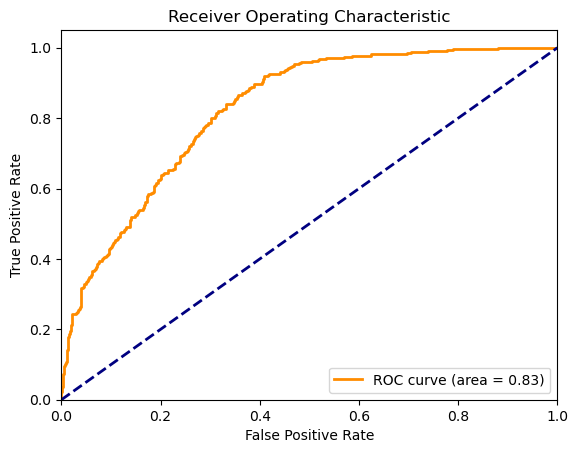

In [379]:
from sklearn.metrics import roc_auc_score, roc_curve
y_probs = rf.predict_proba(test)[:, 1]

# Calculate ROC-AUC
roc_auc = roc_auc_score(test_labels, y_probs)
print(f'ROC-AUC Score: {roc_auc:.2f}')

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, y_probs)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Same features as above with Isolation Forest Implemented

In [380]:
# Initialize the IterativeImputer
imputer = IterativeImputer(max_iter=15, random_state=0)
data = pd.DataFrame(imputer.fit_transform(da2), columns=da2.columns)

# Loop over different contamination values
contamination_values = [0.025, 0.05, 0.1, 0.15, 0.2] 
results = []

for contamination in contamination_values:
    isolation_forest = IsolationForest(contamination=contamination, random_state=0)
    
    # Fit the model and predict outliers
    outliers = isolation_forest.fit_predict(data)
    
    # Filter out the outliers
    filtered_data = data[outliers != -1]
    g = []
    for i in filtered_data['CALI'].values / filtered_data['BS'].values:
        if np.abs(i) > 1.02 or np.abs(i) < 0.98:
            g.append(0)
        else:
            g.append(1)
    
    gg = np.array(g)
    filtered_data['Ra'] = filtered_data['CALI'] / data['BS']
    filtered_data['Ra_C'] = gg
    
    # Test and train data
    test = filtered_data.loc[filtered_data['WELLNUM'] == 5]
    test_labels = test['Ra_C']
    train = filtered_data.loc[filtered_data['WELLNUM'] != 5]
    train_labels = train['Ra_C']
    
    # Drop irrelevant columns
    train.drop(['DTC', 'DTS', 'WELLNUM', 'DEPTH', 'VSH', 'BS', 'CALI', 'Ra', 'Ra_C','SW', 'RDEP','DENC'], axis=1, inplace=True)
    test.drop(['DTC', 'DTS', 'WELLNUM', 'DEPTH', 'VSH', 'BS', 'CALI','Ra', 'Ra_C','SW', 'RDEP','DENC'], axis=1, inplace=True)


    
    # Train the RandomForestClassifier
    rf = RandomForestClassifier(n_estimators=150, max_depth=30, min_samples_leaf=3, random_state = 0)
    rf.fit(train, train_labels)
    predictions = rf.predict(test)
    conf_matrix = confusion_matrix(test_labels, predictions)
    
    # Calculate F1 score
    f1 = f1_score(test_labels, predictions)
    
    # Create a DataFrame from the confusion matrix
    conf_matrix_df = pd.DataFrame(conf_matrix, 
                                  index=['Actual Negative', 'Actual Positive'], 
                                  columns=['Predicted Negative', 'Predicted Positive'])
    
  
    results.append({
        'contamination': contamination,
        'conf_matrix': conf_matrix_df,
        'f1_score': f1
    })

# Display the results
for result in results:
    print(f"Contamination: {result['contamination']}")
    print(result['conf_matrix'])
    print(f"F1 Score: {result['f1_score']}")
    print("\n")


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\desti\AppData\Local\Temp\ipykernel_16684\979642041.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Ra'] = filtered_data['CALI'] / data['BS']
C:\Users\desti\AppData\Local\Temp\ipykernel_16684\979642041.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Ra_C'] = gg
C:\Users\desti\AppDat

Contamination: 0.025
                 Predicted Negative  Predicted Positive
Actual Negative                 257                 296
Actual Positive                  23                 817
F1 Score: 0.8366615463389657


Contamination: 0.05
                 Predicted Negative  Predicted Positive
Actual Negative                 261                 292
Actual Positive                  20                 820
F1 Score: 0.8401639344262294


Contamination: 0.1
                 Predicted Negative  Predicted Positive
Actual Negative                 268                 278
Actual Positive                  28                 811
F1 Score: 0.8412863070539419


Contamination: 0.15
                 Predicted Negative  Predicted Positive
Actual Negative                 243                 271
Actual Positive                  26                 797
F1 Score: 0.8429402432575357


Contamination: 0.2
                 Predicted Negative  Predicted Positive
Actual Negative                 231              

# Another feature analysis

In [381]:
# Initialize the IterativeImputer
imputer = IterativeImputer(max_iter=15, random_state=0)
data = pd.DataFrame(imputer.fit_transform(da2), columns=da2.columns)

# Loop over different contamination values
contamination_values = [0.025, 0.05, 0.1, 0.15, 0.2] 
results = []

for contamination in contamination_values:
    isolation_forest = IsolationForest(contamination=contamination, random_state=0)
    
    # Fit the model and predict outliers
    outliers = isolation_forest.fit_predict(data)
    
    # Filter out the outliers
    filtered_data = data[outliers != -1]
    g = []
    for i in filtered_data['CALI'].values / filtered_data['BS'].values:
        if np.abs(i) > 1.02 or np.abs(i) < 0.98:
            g.append(0)
        else:
            g.append(1)
    
    gg = np.array(g)
    filtered_data['Ra'] = filtered_data['CALI'] / data['BS']
    filtered_data['Ra_C'] = gg
    
    # Test and train data
    test = filtered_data.loc[filtered_data['WELLNUM'] == 5]
    test_labels = test['Ra_C']
    train = filtered_data.loc[filtered_data['WELLNUM'] != 5]
    train_labels = train['Ra_C']
    
    # Drop irrelevant columns
    train.drop(['DTS', 'WELLNUM', 'DEPTH', 'BS', 'CALI', 'Ra', 'Ra_C','ROP'], axis=1, inplace=True)
    test.drop(['DTS', 'WELLNUM', 'DEPTH', 'BS', 'CALI','Ra', 'Ra_C','ROP'], axis=1, inplace=True)

    
    # Train the RandomForestClassifier
    rf = RandomForestClassifier(n_estimators=150, max_depth=30, min_samples_leaf=3, random_state = 0)
    rf.fit(train, train_labels)
    predictions = rf.predict(test)
    conf_matrix = confusion_matrix(test_labels, predictions)
    
    # Calculate F1 score
    f1 = f1_score(test_labels, predictions)
    
    # Create a DataFrame from the confusion matrix
    conf_matrix_df = pd.DataFrame(conf_matrix, 
                                  index=['Actual Negative', 'Actual Positive'], 
                                  columns=['Predicted Negative', 'Predicted Positive'])
    
  
    results.append({
        'contamination': contamination,
        'conf_matrix': conf_matrix_df,
        'f1_score': f1
    })

# Display the results
for result in results:
    print(f"Contamination: {result['contamination']}")
    print(result['conf_matrix'])
    print(f"F1 Score: {result['f1_score']}")
    print("\n")


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\desti\AppData\Local\Temp\ipykernel_16684\4187064604.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Ra'] = filtered_data['CALI'] / data['BS']
C:\Users\desti\AppData\Local\Temp\ipykernel_16684\4187064604.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Ra_C'] = gg
C:\Users\desti\AppD

Contamination: 0.025
                 Predicted Negative  Predicted Positive
Actual Negative                 320                 233
Actual Positive                  48                 792
F1 Score: 0.8493297587131368


Contamination: 0.05
                 Predicted Negative  Predicted Positive
Actual Negative                 306                 247
Actual Positive                  43                 797
F1 Score: 0.846072186836518


Contamination: 0.1
                 Predicted Negative  Predicted Positive
Actual Negative                 313                 233
Actual Positive                  41                 798
F1 Score: 0.8534759358288769


Contamination: 0.15
                 Predicted Negative  Predicted Positive
Actual Negative                 272                 242
Actual Positive                  35                 788
F1 Score: 0.8505126821370751


Contamination: 0.2
                 Predicted Negative  Predicted Positive
Actual Negative                 233               

# Feature Engineering


In [382]:
file_path = 'Borehole_Data.csv'
borehole_data = pd.read_csv(file_path)

# Remove rows where WELLNUM is 0
filtered_data = borehole_data[borehole_data['WELLNUM'] != 0]

# Remove the ROP, DTS, and DEPTH columns
filtered_data = filtered_data.drop(columns=['ROP', 'DTS', 'DEPTH'])

# Initialize the Iterative Imputer
imputer =  IterativeImputer(max_iter = 15, random_state=0)

# Apply the Iterative Imputer to the dataset
imputed_data = imputer.fit_transform(filtered_data)

# Convert the imputed data back into a DataFrame
imputed_df = pd.DataFrame(imputed_data, columns=filtered_data.columns)
g=[]
for i in imputed_df['CALI'].values/imputed_df['BS'].values:
   
   if np.abs(i) > 1.02 or np.abs(i)<0.98:
       g.append(0)
   else:
       g.append(1)    

gg = np.array(g)

imputed_df['Ra'] = imputed_df['CALI']/imputed_df['BS']
imputed_df['Ra_C'] = gg
imputed_df.head()
# Calculate the minimum and maximum GR values
GR_min = imputed_df['GR'].min()
GR_max = imputed_df['GR'].max()

# Calculate the gamma ray index (Igr)
imputed_df['Igr'] = (imputed_df['GR'] - GR_min) / (GR_max - GR_min)


In [383]:
#test and train data
test=imputed_df.loc[imputed_df['WELLNUM'] == 5]
test_labels = test['Ra_C']
train=imputed_df.loc[imputed_df['WELLNUM'] != 5]
train_labels = train['Ra_C']


#drop irrelevant columns
train.drop(['WELLNUM', 'BS', 'CALI', 'Ra', 'Ra_C','GR'], axis=1, inplace=True)
test.drop([ 'WELLNUM', 'BS', 'CALI','Ra', 'Ra_C','GR'], axis=1, inplace=True)

#iforest = IsolationForest(n_estimators = 100, contamination = 0.1)
# = iforest.fit_predict(train)


#print(pre)
rf=RandomForestClassifier(n_estimators=150, max_depth=40, min_samples_leaf=6, max_features = 0.5, random_state = 40)

rf.fit(train,train_labels)
predictions= rf.predict(test)

recall = recall_score(test_labels, predictions)
print(f"Recall: {recall}")

# Calculate precision
precision = precision_score(test_labels, predictions) 
print(f"Precision: {precision}")
f1 = f1_score(predictions,test_labels)
print(f"F1 Score: {f1}")
conf_matrix = confusion_matrix(test_labels, predictions)

conf_matrix_df = pd.DataFrame(conf_matrix, 
                              index=['Actual Negative', 'Actual Positive'], 
                              columns=['Predicted Negative', 'Predicted Positive'])

conf_matrix_df


C:\Users\desti\AppData\Local\Temp\ipykernel_16684\2587126738.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.drop(['WELLNUM', 'BS', 'CALI', 'Ra', 'Ra_C','GR'], axis=1, inplace=True)
C:\Users\desti\AppData\Local\Temp\ipykernel_16684\2587126738.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop([ 'WELLNUM', 'BS', 'CALI','Ra', 'Ra_C','GR'], axis=1, inplace=True)


Recall: 0.9373522458628841
Precision: 0.7610364683301344
F1 Score: 0.840042372881356


,Predicted Negative,Predicted Positive
Actual Negative,311,249
Actual Positive,53,793


# XGBoost with Isolation Forest, try without imputation

In [384]:
# Initialize the IterativeImputer
imputer = IterativeImputer(max_iter=15, random_state=0)
data = pd.DataFrame(imputer.fit_transform(da2), columns=da2.columns)

# Loop over different contamination values
contamination_values = [0.025, 0.05, 0.1, 0.15, 0.2] 
results = []

for contamination in contamination_values:
    isolation_forest = IsolationForest(contamination=contamination, random_state=0)
    
    # Fit the model and predict outliers
    outliers = isolation_forest.fit_predict(data)
    
    # Filter out the outliers
    filtered_data = data[outliers != -1]
    g = []
    for i in filtered_data['CALI'].values / filtered_data['BS'].values:
        if np.abs(i) > 1.02 or np.abs(i) < 0.98:
            g.append(0)
        else:
            g.append(1)
    
    gg = np.array(g)
    filtered_data['Ra'] = filtered_data['CALI'] / data['BS']
    filtered_data['Ra_C'] = gg
    
    # Test and train data
    test = filtered_data.loc[filtered_data['WELLNUM'] == 5]
    test_labels = test['Ra_C']
    train = filtered_data.loc[filtered_data['WELLNUM'] != 5]
    train_labels = train['Ra_C']
    
    # Drop irrelevant columns
    train.drop(['DTC', 'DTS', 'WELLNUM', 'DEPTH', 'VSH', 'BS', 'CALI', 'Ra', 'Ra_C'], axis=1, inplace=True)
    test.drop(['DTC', 'DTS', 'WELLNUM', 'DEPTH', 'VSH', 'BS', 'CALI', 'Ra', 'Ra_C'], axis=1, inplace=True)
    
    # Train the XGBoost Classifier
    xgb = XGBClassifier(n_estimators=150, max_depth=30, min_child_weight=3, random_state=0)
    xgb.fit(train, train_labels)
    predictions = xgb.predict(test)
    conf_matrix = confusion_matrix(test_labels, predictions)
    
    # Calculate F1 score
    f1 = f1_score(test_labels, predictions)
    
    # Create a DataFrame from the confusion matrix
    conf_matrix_df = pd.DataFrame(conf_matrix, 
                                  index=['Actual Negative', 'Actual Positive'], 
                                  columns=['Predicted Negative', 'Predicted Positive'])
    
    # Store the results
    results.append({
        'contamination': contamination,
        'conf_matrix': conf_matrix_df,
        'f1_score': f1
    })

# Display the results
for result in results:
    print(f"Contamination: {result['contamination']}")
    print(result['conf_matrix'])
    print(f"F1 Score: {result['f1_score']}")
    print("\n")


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\desti\AppData\Local\Temp\ipykernel_16684\2372552720.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Ra'] = filtered_data['CALI'] / data['BS']
C:\Users\desti\AppData\Local\Temp\ipykernel_16684\2372552720.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Ra_C'] = gg
C:\Users\desti\AppD

Contamination: 0.025
                 Predicted Negative  Predicted Positive
Actual Negative                 300                 253
Actual Positive                  70                 770
F1 Score: 0.8266237251744498


Contamination: 0.05
                 Predicted Negative  Predicted Positive
Actual Negative                 306                 247
Actual Positive                  77                 763
F1 Score: 0.8248648648648649


Contamination: 0.1
                 Predicted Negative  Predicted Positive
Actual Negative                 296                 250
Actual Positive                  78                 761
F1 Score: 0.8227027027027026


Contamination: 0.15
                 Predicted Negative  Predicted Positive
Actual Negative                 287                 227
Actual Positive                  80                 743
F1 Score: 0.8287785833798105


Contamination: 0.2
                 Predicted Negative  Predicted Positive
Actual Negative                 291              

# XGBoost without Isolation Forest

In [385]:
# Initialize the IterativeImputer
imputer = IterativeImputer(max_iter=15, random_state=0)
data = pd.DataFrame(imputer.fit_transform(da2), columns=da2.columns)

def process_data_and_train(data):
    # Filter data based on custom logic
    g = []
    for i in data['CALI'].values / data['BS'].values:
        if np.abs(i) > 1.02 or np.abs(i) < 0.98:
            g.append(0)
        else:
            g.append(1)
    
    gg = np.array(g)
    data['Ra'] = data['CALI'] / data['BS']
    data['Ra_C'] = gg
    
    # Test and train data
    test = data.loc[data['WELLNUM'] == 5]
    test_labels = test['Ra_C']
    train = data.loc[data['WELLNUM'] != 5]
    train_labels = train['Ra_C']
    
    # Drop irrelevant columns
    train.drop(['DTC', 'DTS', 'WELLNUM', 'DEPTH', 'VSH', 'BS', 'CALI', 'Ra', 'Ra_C'], axis=1, inplace=True)
    test.drop(['DTC', 'DTS', 'WELLNUM', 'DEPTH', 'VSH', 'BS', 'CALI', 'Ra', 'Ra_C'], axis=1, inplace=True)
    

    
    # Train the XGBoost Classifier
    xgb = XGBClassifier(n_estimators=150, max_depth=30, min_child_weight=3, random_state=0)
    xgb.fit(train, train_labels)
    predictions = xgb.predict(test)
    conf_matrix = confusion_matrix(test_labels, predictions)
    
    # Calculate F1 score
    f1 = f1_score(test_labels, predictions)
    
    # Create a DataFrame from the confusion matrix
    conf_matrix_df = pd.DataFrame(conf_matrix, 
                                  index=['Actual Negative', 'Actual Positive'], 
                                  columns=['Predicted Negative', 'Predicted Positive'])
    
    return conf_matrix_df, f1


conf_matrix_df, f1 = process_data_and_train(data)

print("Confusion Matrix:")
print(conf_matrix_df)
print(f"F1 Score: {f1}")


C:\Users\desti\AppData\Local\Temp\ipykernel_16684\3567261207.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.drop(['DTC', 'DTS', 'WELLNUM', 'DEPTH', 'VSH', 'BS', 'CALI', 'Ra', 'Ra_C'], axis=1, inplace=True)
C:\Users\desti\AppData\Local\Temp\ipykernel_16684\3567261207.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop(['DTC', 'DTS', 'WELLNUM', 'DEPTH', 'VSH', 'BS', 'CALI', 'Ra', 'Ra_C'], axis=1, inplace=True)


Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative                 308                 252
Actual Positive                  74                 772
F1 Score: 0.8256684491978609
